In [1]:
# Code for profiling the performance of attention

import torch
import torch.nn as nn
import time
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity
from fvcore.nn import FlopCountAnalysis
import torchprofile
import tracemalloc

input_lengths = [10, 100, 1000, 10000]#, 100000]
devices = ['cpu', 'cuda']
dim = 512

class AttentionModel(nn.Module):
    def __init__(self):
        super(AttentionModel, self).__init__()
        self.Q = nn.Linear(dim, dim)
        self.K = nn.Linear(dim, dim)
        self.V = nn.Linear(dim, dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, input):
        return self.softmax((self.Q(input) @ self.K(input).transpose(1, 2)) / (dim ** 0.5)) @ self.V(input)


def attn_profiler(input_length, device='cpu'):
    device = torch.device(device)

    # Randomly sample words for the input sentence
    input = torch.randn(1, input_length, dim).to(device)
    model = AttentionModel().to(device)

    if device == 'cuda':
        torch.cuda.reset_peak_memory_stats()
        start = time.time()
        model(input)
        end = time.time()
    else:
        start = time.time()
        model(input)
        end = time.time()

    with torch.profiler.profile(
            activities=[
                torch.profiler.ProfilerActivity.CPU,
                torch.profiler.ProfilerActivity.CUDA],
            profile_memory=True,   
            record_shapes=True) as prof:
        model(input)

    stats = prof.key_averages()
    cuda_memory_usage = sum([s.cuda_memory_usage for s in stats if s.cuda_memory_usage > 0])
    cpu_memory_usage = sum([s.cpu_memory_usage for s in stats if s.cpu_memory_usage > 0])
    memory_usage = cuda_memory_usage if device == torch.device('cuda') else cpu_memory_usage
    
    runtime = end - start
    flop_counter = FlopCountAnalysis(model, input)
    flops = flop_counter.total()
    
    print(f"Device: {device}, Input length: {input_length}, Time: {runtime:.2e}, FLOPS: {flops:.2e}, Memory: {memory_usage:.2e}")

    # del model

    return {
        "input_length": input_length,
        "device": device,
        "time": runtime,
        "flops": flops,
        "memory": memory_usage,        
    }


f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.43e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 0.00e+00, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 5.19e-04, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 5.14e-04, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 1.55e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 5.16e-04, FLOPS: 8.89e+07, Memory: 1.84e+06


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 1000, Time: 4.62e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 5.10e-04, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.88e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 5.10e-04, FLOPS: 1.10e+11, Memory: 2.17e+09
[{'input_length': 10, 'device': device(type='cpu'), 'time': 0.0005190372467041016, 'flops': 7966720, 'memory': 165852}, {'input_length': 100, 'device': device(type='cpu'), 'time': 0.0015454292297363281, 'flops': 88883200, 'memory': 1838412}, {'input_length': 1000, 'device': device(type='cpu'), 'time': 0.046201467514038086, 'flops': 1810432000, 'memory': 36384008}, {'input_length': 10000, 'device': device(type='cpu'), 'time': 0.28757166862487793, 'flops': 110264320000, 'memory': 2163840008}]
[{'input_length': 10, 'device': device(type='cuda'), 'time': 0.0005142688751220703, 'flops': 7966720, 'memory': 166400}, {'input_length': 100, 'device': device(type='cuda'), 'time': 0.0005161762237548828, 'flops': 88883200, 'memory': 1840640}, {'input_length': 1000, 'device': device(type='cuda'), 'time': 0.0005102157592773438, 'flops

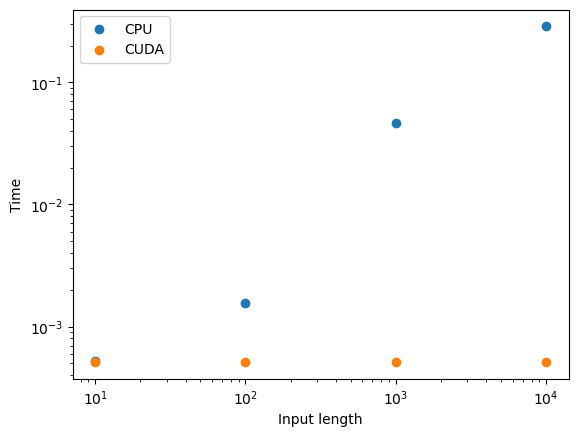

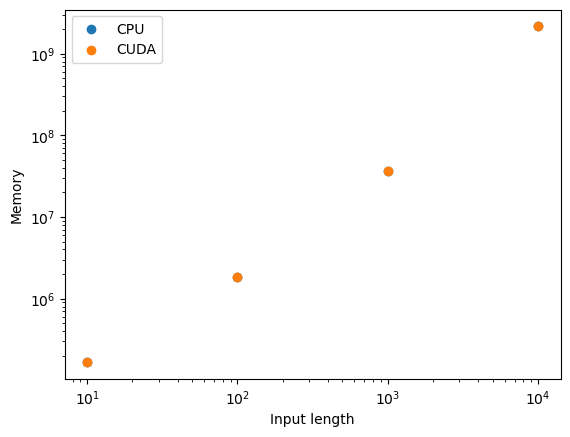

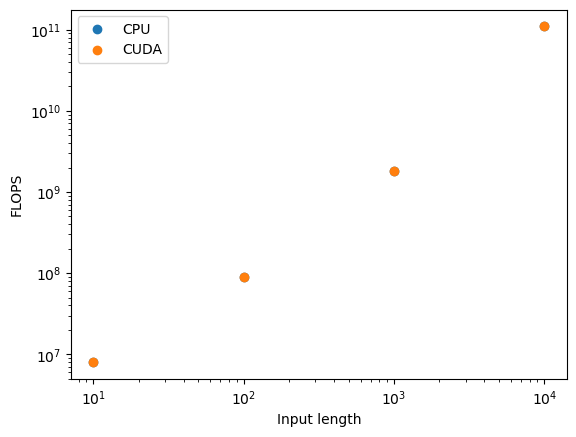

In [5]:
# Do a warmup run
attn_profiler(10000)
attn_profiler(10000, 'cuda')

# Run the profiler
cpu_results = []
cuda_results = []
for input_length in input_lengths:
    for device in devices:
        result = attn_profiler(input_length, device)
        if device == 'cpu':
            cpu_results.append(result)
        else:
            cuda_results.append(result)

print(cpu_results)
print(cuda_results)
    
import matplotlib.pyplot as plt

# Plot runtime vs input length
cpu_times = [result['time'] for result in cpu_results]
cuda_times = [result['time'] for result in cuda_results]

plt.scatter(input_lengths, cpu_times, label='CPU')
plt.scatter(input_lengths, cuda_times, label='CUDA')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Input length')
plt.ylabel('Time')
plt.legend()

plt.show()


# Plot memory vs input length
cpu_memory = [result['memory'] for result in cpu_results]
cuda_memory = [result['memory'] for result in cuda_results]

plt.scatter(input_lengths, cpu_memory, label='CPU')
plt.scatter(input_lengths, cuda_memory, label='CUDA')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Input length')
plt.ylabel('Memory')
plt.legend()

plt.show()

# Plot flops vs input length
cpu_flops = [result['flops'] for result in cpu_results]
cuda_flops = [result['flops'] for result in cuda_results]

plt.scatter(input_lengths, cpu_flops, label='CPU')
plt.scatter(input_lengths, cuda_flops, label='CUDA')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Input length')
plt.ylabel('FLOPS')
plt.legend()

plt.show()
